# Chapter 14: A Basic Monte Carlo Algorithm

## Learning Objectives

By the end of this lecture, you should be able to

1. Derive the Metropolis algorithm for sampling from a probability distribution.
2. Implement a basic Metropolis algorithm in Python.
3. Apply the Metropolis algorithm to sample thermally accessible configurations of a simple system.

---

## Introduction

Evaluating statistical averages of the form

$$
\langle A \rangle = \frac{\int d\mathbf{r}^N \, e^{-\beta U(\mathbf{r}^N)} A(\mathbf{r}^N)}{\int d\mathbf{r}^N \, e^{-\beta U(\mathbf{r}^N)}} = \int d\mathbf{r}^N \, p(\mathbf{r}^N) A(\mathbf{r}^N),
$$

where $\mathbf{r}^N$ represents the coordinates of a system of $N$ particles, $U(\mathbf{r}^N)$ is the potential energy, $\beta = 1/(k_B T)$ is the inverse temperature, $p(\mathbf{r}^N) = e^{-\beta U(\mathbf{r}^N)}/Z$ is the Boltzmann probability distribution, and $Z$ is the partition function, can be challenging due to the high dimensionality of the integral. The **Metropolis algorithm** provides a way to sample configurations from $p(\mathbf{r}^N)$, allowing us to approximate the average $\langle A \rangle$ by

$$
\langle A \rangle \approx \frac{1}{M} \sum_{i=1}^M A(\mathbf{r}^N_i),
$$

where $M$ is the number of sampled configurations $\mathbf{r}^N_i$.

---

## The Metropolis Algorithm: "Measuring the Depth of the Mississippi"

![The Mississippi River](mississippi_river_depth.png)

Traditional numerical integration methods, like quadrature, evaluate the integrand at predefined grid points, which can be inefficient in high-dimensional spaces or when the integrand is significant only in a small region of the domain. This is analogous to measuring the depth of the Mississippi River at regular intervals, regardless of whether those points are over water or land. The Metropolis algorithm improves upon this by focusing computational effort on regions where the integrand (or probability density) is large—much like concentrating measurements over the river itself rather than the surrounding land.

### Derivation of the Metropolis Algorithm

To sample from the probability distribution $p(\mathbf{r}^N)$, we construct a **Markov chain** where the probability of transitioning from one configuration to another depends only on those two configurations.

#### Detailed Balance Condition

For the Markov chain to converge to the desired distribution $p(\mathbf{r}^N)$, it must satisfy the **detailed balance condition**

$$
\pi(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}}) \, p(\mathbf{r}_{\text{old}}) = \pi(\mathbf{r}_{\text{new}} \rightarrow \mathbf{r}_{\text{old}}) \, p(\mathbf{r}_{\text{new}}),
$$

where $\pi(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}})$ is the total transition probability from the old configuration to the new one. We can decompose $\pi$ into two parts:

1. **Proposal probability** $\alpha(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}})$: The probability of proposing a move to $\mathbf{r}_{\text{new}}$.
2. **Acceptance probability** $\text{acc}(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}})$: The probability of accepting the proposed move.

Thus,

$$
\pi(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}}) = \alpha(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}}) \, \text{acc}(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}}).
$$

If we choose a **symmetric proposal distribution** such that

$$
\alpha(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}}) = \alpha(\mathbf{r}_{\text{new}} \rightarrow \mathbf{r}_{\text{old}}),
$$

the detailed balance condition simplifies to

$$
\frac{\text{acc}(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}})}{\text{acc}(\mathbf{r}_{\text{new}} \rightarrow \mathbf{r}_{\text{old}})} = \frac{p(\mathbf{r}_{\text{new}})}{p(\mathbf{r}_{\text{old}})} = e^{-\beta [U(\mathbf{r}_{\text{new}}) - U(\mathbf{r}_{\text{old}})]}.
$$

#### Acceptance Probability

Metropolis *et al.* proposed setting the acceptance probability to

$$
\text{acc}(\mathbf{r}_{\text{old}} \rightarrow \mathbf{r}_{\text{new}}) = \min\left[1, e^{-\beta [U(\mathbf{r}_{\text{new}}) - U(\mathbf{r}_{\text{old}})]}\right].
$$

This choice satisfies the detailed balance condition and ensures that the Markov chain will converge to the Boltzmann distribution.

### The Metropolis Algorithm Steps

1. **Initialization**: Choose an initial configuration $\mathbf{r}_{\text{old}}$.
2. **Proposal**: Generate a new configuration $\mathbf{r}_{\text{new}}$ by making a small random change to $\mathbf{r}_{\text{old}}$.
3. **Compute Acceptance Probability**:

   $$
   \text{acc} = \min\left[1, e^{-\beta [U(\mathbf{r}_{\text{new}}) - U(\mathbf{r}_{\text{old}})]}\right].
   $$

4. **Accept or Reject Move**:
   - Generate a random number $r \in [0, 1]$.
   - If $r < \text{acc}$, accept the move ($\mathbf{r}_{\text{new}}$ becomes the current configuration).
   - Else, reject the move (retain $\mathbf{r}_{\text{old}}$).
5. **Iteration**: Repeat steps 2–4 for a large number of steps to sample the distribution.

---

## Example: Sampling a Classical Morse Oscillator

The **Morse potential** models the potential energy of a diatomic molecule

$$
U(x) = D_e \left[1 - e^{-\alpha (x - x_e)}\right]^2,
$$

where $D_e$ is the dissociation energy, $x_e$ is the equilibrium bond length, $\alpha$ determines the width of the potential well, and $x$ is the bond length.

### Visualization of the Morse Potential

![Morse Oscillator](morse_potential.png)

The potential well is asymmetric, leading to interesting thermal properties like thermal expansion.

---

## Implementing the Metropolis Algorithm in Python

We'll implement the Metropolis algorithm to sample configurations from the Boltzmann distribution of the Morse oscillator.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, eV

# Set random seed for reproducibility
np.random.seed(42)

# Constants
k_B = k / eV  # Boltzmann constant in eV/K

# Morse potential parameters
D_e = 1.0      # Dissociation energy in eV
x_e = 1.0      # Equilibrium bond length
alpha = 1.5    # Width parameter in 1/Å
T = 300.0      # Temperature in K
beta = 1.0 / (k_B * T)

# Define the Morse potential function
def morse_potential(x):
    return D_e * (1 - np.exp(-alpha * (x - x_e)))**2

# Define the Metropolis algorithm
def metropolis_sampling(x_init, n_steps, beta, delta):
    x = x_init
    samples = []
    for _ in range(n_steps):
        # Propose a new position
        x_new = x + np.random.uniform(-delta, delta)
        
        # Compute the change in potential energy
        delta_U = morse_potential(x_new) - morse_potential(x)
        
        # Acceptance probability
        acceptance_prob = min(1.0, np.exp(-beta * delta_U))
        
        # Accept or reject the new position
        if np.random.rand() < acceptance_prob:
            x = x_new  # Accept the move
        
        samples.append(x)
    return np.array(samples)

### Explanation of the Code

- **`morse_potential(x)`**: Computes the Morse potential at position `x`.
- **`metropolis_sampling(x_init, n_steps, beta, delta)`**:
  - `x_init`: Initial position.
  - `n_steps`: Number of sampling steps.
  - `beta`: Inverse temperature.
  - `delta`: Maximum change allowed in a single move (controls step size).
  - The function returns an array of sampled positions.

---

## Running the Simulation

In [2]:
# Simulation parameters
x_initial = x_e  # Start at equilibrium position
n_equilibration = 10000
n_sampling = 50000
delta = 0.1      # Maximum step size

# Equilibration phase
x_equilibrated = metropolis_sampling(x_initial, n_equilibration, beta, delta)

# Sampling phase
x_samples = metropolis_sampling(x_equilibrated[-1], n_sampling, beta, delta)

```{note}
The **equilibration phase** allows the system to reach equilibrium before sampling. We discard these initial samples to ensure the system is in a stable configuration. The **sampling phase** collects samples for analysis.
```

---

## Analyzing the Results

### Average Bond Length

In [3]:
# Compute the average bond length
x_avg = np.mean(x_samples)
print(f"Average bond length at {T} K: {x_avg:.4f} Å")

Average bond length at 300.0 K: 1.0133 Å


### Plotting the Results

````{margin}
```{note}
"Time" here refers to the number of sampling steps.
```
````

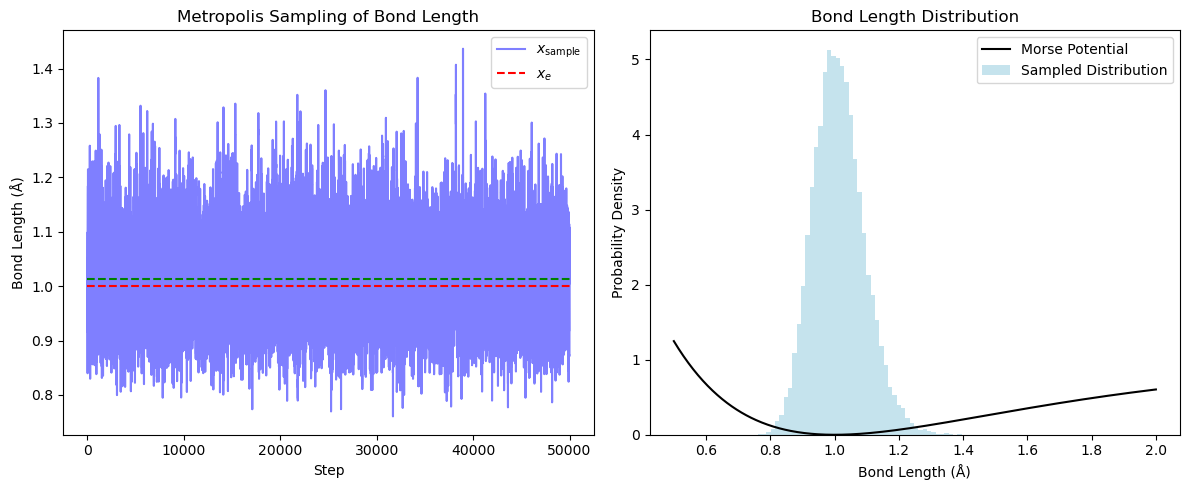

In [4]:
# Plotting the sampled positions over "time"
plt.figure(figsize=(12, 5))

# Left: "Time series" of bond lengths
plt.subplot(1, 2, 1)
plt.plot(x_samples, color='blue', alpha=0.5)
plt.hlines([x_e, x_avg], xmin=0, xmax=n_sampling, colors=['red', 'green'], linestyles='dashed')
plt.xlabel('Step')
plt.ylabel('Bond Length (Å)')
plt.title('Metropolis Sampling of Bond Length')
plt.legend([r'$x_{\text{sample}}$', r'$x_e$', r'$\langle x \rangle$'])

# Right: Histogram and potential
plt.subplot(1, 2, 2)
x_range = np.linspace(x_e - 0.5, x_e + 1.0, 500)
plt.plot(x_range, morse_potential(x_range), 'k-', label='Morse Potential')
plt.hist(x_samples, bins=50, density=True, color='lightblue', alpha=0.7, label='Sampled Distribution')
plt.xlabel('Bond Length (Å)')
plt.ylabel('Probability Density')
plt.title('Bond Length Distribution')
plt.legend()

plt.tight_layout()
plt.show()

```{admonition} Interpretation
:class: tip
The **left plot** shows how the bond length fluctuates over "time" during the simulation. The **right plot** overlays the Morse potential with the histogram of sampled bond lengths, showing that the sampling is concentrated near the minimum of the potential but is skewed towards longer bond lengths due to the asymmetry of the Morse potential.
```

---

## Thermal Expansion of the Morse Oscillator

We now investigate how the average bond length changes with temperature, illustrating thermal expansion.

### Simulation Over a Range of Temperatures

In [5]:
# Temperature range from 100 K to 1000 K
T_values = np.linspace(100, 1000, 10)
x_averages = []

for T in T_values:
    beta = 1.0 / (k_B * T)
    # Re-equilibrate at new temperature
    _ = metropolis_sampling(x_e, n_equilibration, beta, delta)
    # Sample
    x_samples = metropolis_sampling(x_e, n_sampling, beta, delta)
    # Compute average bond length
    x_avg = np.mean(x_samples)
    x_averages.append(x_avg)

# Convert results to numpy arrays
T_values = np.array(T_values)
x_averages = np.array(x_averages)

### Plotting Thermal Expansion

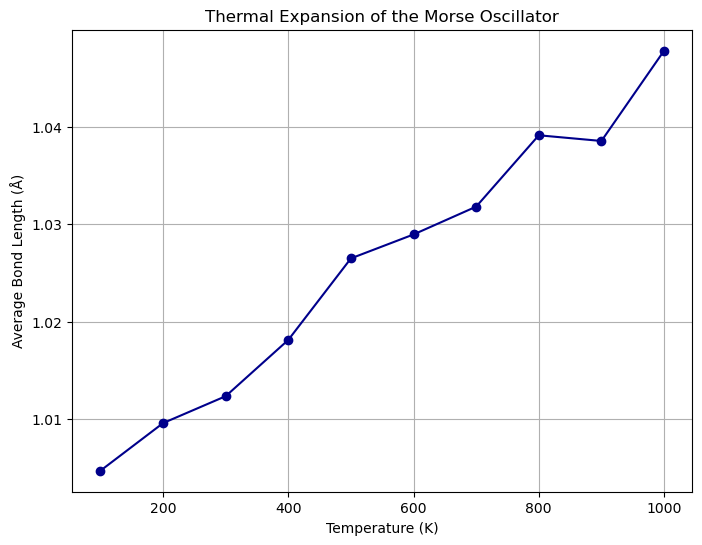

In [6]:
# Plot average bond length vs. temperature
plt.figure(figsize=(8, 6))
plt.plot(T_values, x_averages, 'o-', color='darkblue')
plt.xlabel('Temperature (K)')
plt.ylabel('Average Bond Length (Å)')
plt.title('Thermal Expansion of the Morse Oscillator')
plt.grid(True)
plt.show()

```{admonition} Interpretation
:class: tip
The plot shows that the average bond length increases with temperature. This is due to the anharmonicity of the Morse potential, which causes asymmetry in the potential energy well.
```

---

## Summary

- The **Metropolis algorithm** is a powerful tool for sampling from complex probability distributions, especially in high-dimensional spaces.
- By satisfying the **detailed balance condition**, the algorithm ensures convergence to the desired distribution.
- Applying the algorithm to the **Morse oscillator** demonstrates thermal expansion due to the anharmonicity of the potential.
- The Morse oscillator's average bond length increases with temperature, illustrating how molecular vibrations contribute to macroscopic thermal expansion.

---

```{admonition} Additional Notes
:class: note
- **Choice of Step Size (`delta`)**: The step size should be tuned to achieve an acceptance ratio (accepted moves over total proposed moves) of about 30%–50% for efficient sampling.
- **Autocorrelation**: Successive samples may be correlated. To obtain independent samples, one can sample every few steps (thinning) or analyze the autocorrelation "time."
- **Higher Dimensions**: The algorithm extends to systems with many particles by proposing moves in the multidimensional configuration space.
```

---

## References

- Metropolis, N., et al. "Equation of State Calculations by Fast Computing Machines." *The Journal of Chemical Physics* 21.6 (1953): 1087-1092. [https://doi.org/10.1063/1.1699114](https://doi.org/10.1063/1.1699114)
- Frenkel, D., and B. Smit. *Understanding Molecular Simulation: From Algorithms to Applications*. Academic Press, 2023. [https://doi.org/10.1016/C2009-0-63921-0](https://doi.org/10.1016/C2009-0-63921-0)